In [1]:
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os, sys

import cv2
from torch.utils.data import Dataset
from torchvision import transforms

from tqdm import tqdm
import random
from pdb import set_trace
import numpy as np
from video_restore.data import train_dataset, get_test_data, load_video_frames
from video_restore.model import VideoRestorationCNN, cnn2, ImageRestorationModel, ComplexImageRestorationModel, VComplexImageRestorationModel
from video_restore.utils import save_model, load_model, extract_patch, compute_loss, save_tensor_as_video, referenced_quality_estimation, charbonnier_loss

from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from time import time
import matplotlib.pyplot as plt 
import os
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim


In [60]:
model = VComplexImageRestorationModel()
model = load_model(my_model=model, save_path="./checkpoints/base_big/model_weight_1300_epoch_log.pt")
model = model.to("cuda")

Call Model 4


In [4]:
non_ref_video_names = ["CoverSong_720P-7360_crf_10_ss_00_t_20.0", "Lecture_1080P-011f_ss_00_t_20.0_INGEST", "LiveMusic_360P-1d94_crf_10_ss_00_t_20.0", "Sniper_INGEST"]
ref_video_names = ["MeridianTalk_INGEST", "TunnelFlag_INGEST"]

non_ref_video_names = non_ref_video_names + ref_video_names
non_ref_video_names_to_fps = {
    "CoverSong_720P-7360_crf_10_ss_00_t_20.0": 30, "Lecture_1080P-011f_ss_00_t_20.0_INGEST": 30, "LiveMusic_360P-1d94_crf_10_ss_00_t_20.0": 30, "Sniper_INGEST": 30,
    "MeridianTalk_INGEST": 59.94, "TunnelFlag_INGEST": 59.94
}


In [5]:
train_video_names = [f"{i}_51" for i in range(1, 1001)]
train_video_names = [f for f in os.listdir("/data1/seungeon/ojt1/x_image") if not f.endswith("_51")]
train_video_names.sort()

In [6]:
merdian_gt = load_video_frames(os.path.join("test/GT", "MeridianTalk_INGEST.y4m"))
tunnel_gt = load_video_frames(os.path.join("test/GT", "TunnelFlag_INGEST.y4m"))

gt_videos = {"MeridianTalk_INGEST": merdian_gt,
             "TunnelFlag_INGEST": tunnel_gt}

In [7]:
merdian_x = load_video_frames(os.path.join("test", "MeridianTalk_INGEST.mp4"))
tunnel_x = load_video_frames(os.path.join("test", "TunnelFlag_INGEST.mp4"))
x_videos = {"MeridianTalk_INGEST": merdian_x,
             "TunnelFlag_INGEST": tunnel_x}

In [8]:
test_videos = []
for video_idx in range(len(non_ref_video_names)):

    videos = load_video_frames(os.path.join("test", non_ref_video_names[video_idx]+".mp4"))
    test_videos.append(videos)

In [61]:
#Test Video Inference
video_save = True
image_save = True
short = False

for video_idx in range(len(non_ref_video_names)):

    #videos = load_video_frames(os.path.join("test", non_ref_video_names[video_idx]+".mp4"))
    videos = test_videos[video_idx]
    tensor_videos = torch.tensor(np.stack(videos), dtype=torch.float32)/255.0
    if short: 
        tensor_videos = tensor_videos[:10]
    loss_list = []
    restored = []
    psnr_list = []
    ssim_list = []

    if non_ref_video_names[video_idx] in ref_video_names:
        gt_video = gt_videos[non_ref_video_names[video_idx]]
        tensor_gt = torch.tensor(np.stack(gt_video))/255.0

        for idx, tensor_frmae in tqdm(enumerate(tensor_videos)):
            with torch.no_grad():
                tensor_frmae = tensor_frmae.cuda()
                output = model(tensor_frmae.unsqueeze(0))
                output = output.squeeze(0)

                restored.append(output.detach().cpu())

                gt_frame = tensor_gt[idx].permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
                output_frame = output.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)

                # PSNR 계산
                psnr_value = compare_psnr(gt_frame, output_frame, data_range=1.0)

                gt_frame = cv2.cvtColor(gt_frame*255, cv2.COLOR_BGR2GRAY)
                output_frame = cv2.cvtColor(output_frame*255, cv2.COLOR_BGR2GRAY)

                ssim_score = ssim(gt_frame.astype(np.uint8), output_frame.astype(np.uint8), data_range=255)
                ssim_list.append(ssim_score)


                psnr_list.append(psnr_value)
                loss = torch.mean((tensor_gt[idx] - output.detach().cpu())**2)
            loss_list.append(loss.item())
        print(non_ref_video_names[video_idx])
        print(f"PSNR: {sum(psnr_list)/len(psnr_list)}")
        print(f"SSIM: {sum(ssim_list)/len(ssim_list)}")

    else:
        for tensor_frmae in tqdm(tensor_videos):
            with torch.no_grad():
                tensor_frmae = tensor_frmae.cuda()
                output = model(tensor_frmae.unsqueeze(0))
                output = output.squeeze(0)

                restored.append(output.detach().cpu())


                loss = torch.mean((tensor_frmae - output)**2)
            loss_list.append(loss.item())
    
    if not os.path.exists(os.path.join("inference_image", non_ref_video_names[video_idx])):
        os.mkdir(os.path.join("inference_image", non_ref_video_names[video_idx]))

    if video_save:
        save_tensor_as_video(tensor=torch.stack(restored), video_path="./restored_"+non_ref_video_names[video_idx]+".mp4", fps=non_ref_video_names_to_fps[non_ref_video_names[video_idx]])

    for idx, img in enumerate(restored):
        if image_save:
            img = (img*255.0).permute(1,2,0).detach().cpu().numpy().astype(np.uint8)
            #img = np.int64(img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            save_path = os.path.join("inference_image", non_ref_video_names[video_idx], str(idx)+".png")
            cv2.imwrite(save_path, img)

    print(non_ref_video_names[video_idx], "MSE: ", sum(loss_list)/len(loss_list))

100%|██████████| 600/600 [02:12<00:00,  4.52it/s]


Video saved to ./restored_CoverSong_720P-7360_crf_10_ss_00_t_20.0.mp4
CoverSong_720P-7360_crf_10_ss_00_t_20.0 MSE:  0.0006359358745006223


100%|██████████| 120/120 [00:44<00:00,  2.70it/s]


Video saved to ./restored_Lecture_1080P-011f_ss_00_t_20.0_INGEST.mp4
Lecture_1080P-011f_ss_00_t_20.0_INGEST MSE:  0.0017050578443255895


100%|██████████| 600/600 [00:34<00:00, 17.64it/s]


Video saved to ./restored_LiveMusic_360P-1d94_crf_10_ss_00_t_20.0.mp4
LiveMusic_360P-1d94_crf_10_ss_00_t_20.0 MSE:  0.0036936616672513384


100%|██████████| 130/130 [01:04<00:00,  2.02it/s]


Video saved to ./restored_Sniper_INGEST.mp4
Sniper_INGEST MSE:  0.0011099149631963183


120it [01:57,  1.02it/s]


MeridianTalk_INGEST
PSNR: 30.138430656628618
SSIM: 0.882418296190335
Video saved to ./restored_MeridianTalk_INGEST.mp4
MeridianTalk_INGEST MSE:  0.0009687670103933972


120it [01:55,  1.04it/s]


TunnelFlag_INGEST
PSNR: 26.828288744227187
SSIM: 0.8948487255680695
Video saved to ./restored_TunnelFlag_INGEST.mp4
TunnelFlag_INGEST MSE:  0.0020766203126792488


In [16]:
for video_idx in range(len(ref_video_names)):

    #videos = load_video_frames(os.path.join("test", non_ref_video_names[video_idx]+".mp4"))
    y_video = gt_videos[ref_video_names[video_idx]]
    #y_video = torch.tensor(np.stack(y_video), dtype=torch.float32)/255.0
    x_video = x_videos[ref_video_names[video_idx]]
    #x_video = torch.tensor(np.stack(x_video), dtype=torch.float32)/255.0

    print(y_video[0].shape, x_video[0].shape)
    loss_list = []
    restored = []
    psnr_list = []
    ssim_list = []

    for idx, x_frame in tqdm(enumerate(x_video)):
        y_frmae = np.transpose(y_video[idx], (1,2,0)) 
        x_frame = np.transpose(x_frame, (1,2,0))
        
        psnr_value = compare_psnr(y_frmae, x_frame, data_range=255.0)

        y_frmae = cv2.cvtColor(y_frmae, cv2.COLOR_BGR2GRAY)
        x_frame = cv2.cvtColor(x_frame, cv2.COLOR_BGR2GRAY)

        ssim_score = ssim(y_frmae.astype(np.uint8), x_frame.astype(np.uint8), data_range=255)

        psnr_list.append(psnr_value)
        ssim_list.append(ssim_score)
    print(ref_video_names[video_idx])
    print(f"PSNR: {sum(psnr_list)/len(psnr_list)}")
    print(f"SSIM: {sum(ssim_list)/len(ssim_list)}")



(3, 1080, 1920) (3, 1080, 1920)


120it [00:48,  2.50it/s]


MeridianTalk_INGEST
PSNR: 35.79791750990601
SSIM: 0.8985088097478646
(3, 1080, 1920) (3, 1080, 1920)


120it [00:47,  2.52it/s]

TunnelFlag_INGEST
PSNR: 29.518194556895597
SSIM: 0.894346940438383


In [21]:
def compute_ssim(img1, img2):
    #img1: prediction
    #img2: answer
    if type(img1) != type(img2):
        raise ValueError("Two input images must have same type")
    if img1.shape != img2.shape:
        raise ValueError("Two input images must have same image shape")


    
    if isinstance(img1, np.ndarray):
        num_dim = len(img1.shape)

        if num_dim != 3:
            raise ValueError("Input image of function must be 3 dimension image")
        else:
            one, two, three = img1.shape

            if one == 3:     #c, h, w case
                img1 = np.transpose(img1, (1, 2, 0))
                img2 = np.transpose(img2, (1, 2, 0))
            elif three == 3:
                pass
            else:
                raise ValueError("Input image must have three channels")
            
    elif isinstance(img1, torch.Tensor):
        return compute_ssim(img1.detach().cpu().numpy(), img2.detach().cpu().numpy())


    min_val, max_val = np.min(img1), np.max(img2)

    if max_val > 1:
        scale_factor = 1.0
    else:
        scale_factor = 255.0

    output_frame = cv2.cvtColor(img1*scale_factor, cv2.COLOR_BGR2GRAY)
    gt_frame = cv2.cvtColor(img2*scale_factor, cv2.COLOR_BGR2GRAY)

    ssim_score = ssim(gt_frame.astype(np.uint8), output_frame.astype(np.uint8), data_range=255)

    return ssim_score
            


            


0.87794019688323


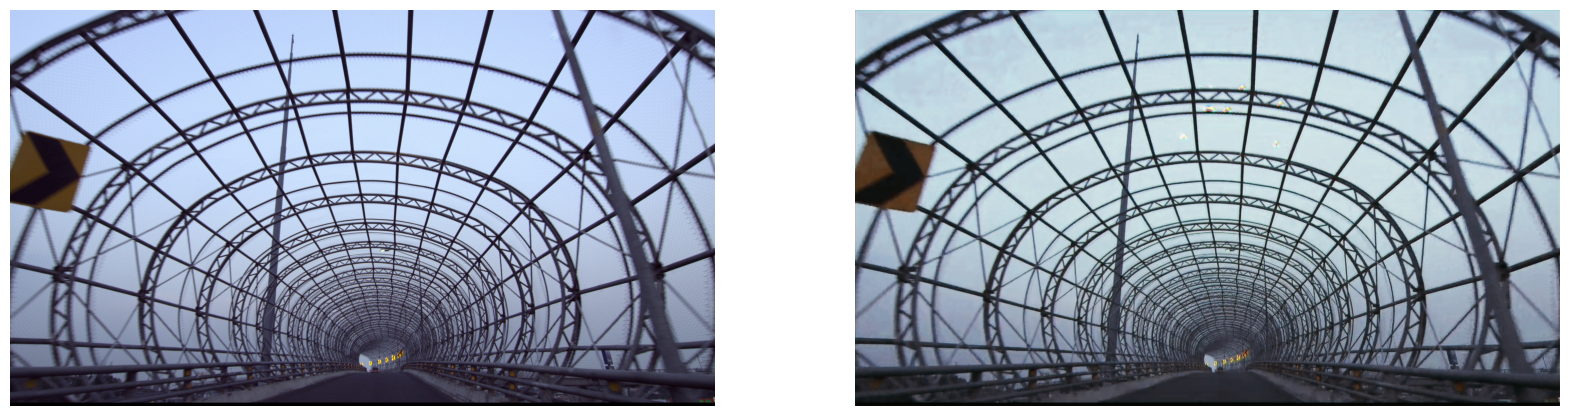

In [34]:
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.imshow(tensor_gt[9].permute(1,2,0).detach().cpu().numpy())
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(output.permute(1,2,0).detach().cpu().numpy())
plt.axis("off")

print(compute_ssim(output, tensor_gt[9]))

In [22]:
compute_ssim(output, tensor_gt[-1])

0.2856836506263968

In [32]:
for video_idx in range(0, len(train_video_names)):

    videos = load_video_frames(os.path.join("train/encoded_full", train_video_names[video_idx]+".mp4"))

    tensor_videos = torch.tensor(np.stack(videos))/255.0
    tensor_videos = tensor_videos[:10]

    loss_list = []
    restored = []

    
    for tensor_frmae in tqdm(tensor_videos):
        with torch.no_grad():
            tensor_frmae = tensor_frmae.cuda()
            output = model(tensor_frmae.unsqueeze(0))
            output = output.squeeze(0)

            restored.append(output)


            loss = torch.mean((tensor_frmae - output)**2)
        loss_list.append(loss.item())

    if not os.path.exists(os.path.join("train_inference_image", train_video_names[video_idx])):
        os.makedirs(os.path.join("train_inference_image", train_video_names[video_idx]))

    for idx, img in enumerate(restored):
        img = (img*255).permute(1,2,0).detach().cpu().numpy().astype(np.uint8)
        #img = np.int64(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        save_path = os.path.join("train_inference_image", train_video_names[video_idx], str(idx)+".png")
        cv2.imwrite(save_path, img)

    print(train_video_names[video_idx], "MSE: ", sum(loss_list)/len(loss_list))

100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


1000_33 MSE:  3.879962641804013e-05


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


1000_40 MSE:  4.578457046591211e-05


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


100_37 MSE:  0.001100253197364509


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


100_40 MSE:  0.0011005166685208677


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


101_40 MSE:  0.0013354090857319533


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


101_42 MSE:  0.0012934498372487724


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


102_39 MSE:  0.00048205690109170973


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


102_40 MSE:  0.000478353034122847


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


103_37 MSE:  0.0010255607892759144


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


103_40 MSE:  0.0009700768045149743


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


104_38 MSE:  0.0020732167176902294


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


104_40 MSE:  0.002086527633946389


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


105_39 MSE:  0.0007517067191656679


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


105_40 MSE:  0.0007181278720963747


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


106_40 MSE:  0.0003121500456472859


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


107_40 MSE:  0.001623225840739906


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


107_41 MSE:  0.001583766599651426


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


108_40 MSE:  0.001201541442424059


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


108_43 MSE:  0.0010359626496210695


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


109_40 MSE:  0.0015214095008559525


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


109_49 MSE:  0.001362492295447737


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


10_37 MSE:  0.0005284938553813845


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


10_40 MSE:  0.000521804770687595


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


110_31 MSE:  0.0007378760259598493


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


110_40 MSE:  0.0007122880080714822


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


111_40 MSE:  0.0007776452112011611


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


111_45 MSE:  0.0007462990062776953


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


112_33 MSE:  0.0012740906211547553


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


112_40 MSE:  0.0010971002513542772


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


113_37 MSE:  0.0026695794891566037


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


113_40 MSE:  0.00262068638112396


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


114_32 MSE:  0.002297031995840371


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


114_40 MSE:  0.0021099342964589598


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


115_40 MSE:  0.0011372736655175686


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


115_41 MSE:  0.001127271179575473


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


116_40 MSE:  0.0001913921456434764


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


117_40 MSE:  0.0014282665797509253


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


117_48 MSE:  0.0010950069292448461


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


118_34 MSE:  0.0015137873240746557


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


118_40 MSE:  0.0013469113036990166


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


119_33 MSE:  0.002256437623873353


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


119_40 MSE:  0.002094520255923271


 50%|█████     | 5/10 [00:02<00:02,  1.71it/s]


KeyboardInterrupt: 